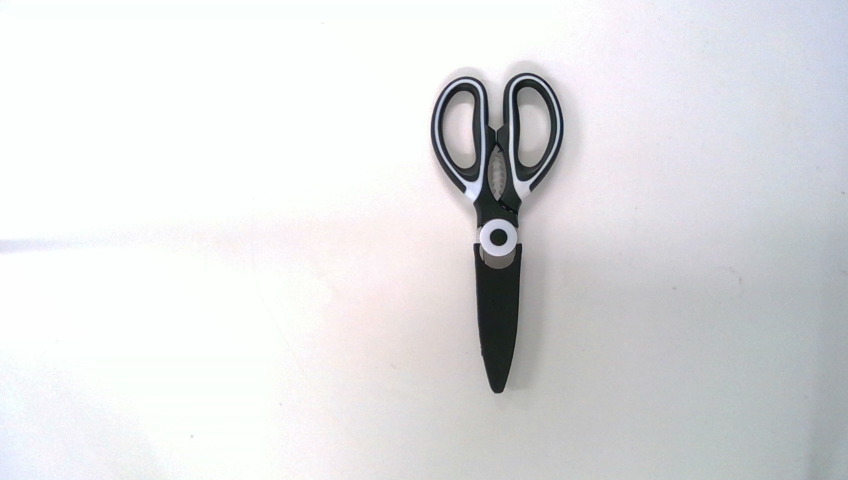

In [126]:
import rospy
import ros_numpy
import matplotlib.pyplot as plt
import numpy as np
from sensor_msgs.msg import Image as ImageMsg
from PIL import Image

rospy.init_node('dino', anonymous=True)

rgb_message_wrist = rospy.wait_for_message("d405/color/image_rect_raw", ImageMsg)
depth_message_wrist = rospy.wait_for_message("d405/aligned_depth_to_color/image_raw", ImageMsg)
rgb_data_wrist = ros_numpy.numpify(rgb_message_wrist)
depth_data_wrist = ros_numpy.numpify(depth_message_wrist)
rgb_image_wrist = Image.fromarray(rgb_data_wrist)
depth_image_wrist = Image.fromarray(depth_data_wrist)
rgb_image_wrist

In [127]:
DIR = "scissor"

rgb_image_wrist.save(f"data/{DIR}/live_wrist_rgb.png")
depth_image_wrist.save(f"data/{DIR}/live_wrist_depth.png")

Using cache found in /home/yilong/.cache/torch/hub/facebookresearch_dino_main
/home/yilong/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


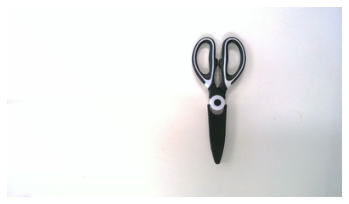

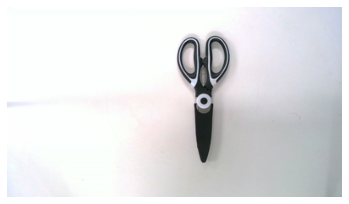

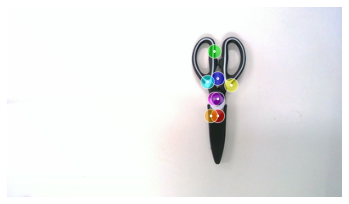

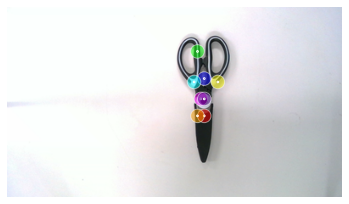

In [128]:
import matplotlib.pyplot as plt
import torch
from DinoViT.correspondences import find_correspondences, draw_correspondences

num_pairs = 8 #@param
load_size = 224 #@param
layer = 9 #@param
facet = 'key' #@param
bin=True #@param
thresh=0.05 #@param
model_type='dino_vits8' #@param
stride=4 #@param

image_path1="data/scissor/demo_wrist_rgb.png"
image_path2="data/scissor/live_wrist_rgb.png"

with torch.no_grad():
    points1, points2, image1_pil, image2_pil = find_correspondences(image_path1, image_path2, num_pairs, load_size, layer,
                                                                   facet, bin, thresh, model_type, stride)
fig_1, ax1 = plt.subplots()
ax1.axis('off')
ax1.imshow(image1_pil)
fig_2, ax2 = plt.subplots()
ax2.axis('off')
ax2.imshow(image2_pil)


fig1, fig2 = draw_correspondences(points1, points2, image1_pil, image2_pil)
plt.show()

In [129]:
demo_depth = np.array(Image.open("data/{0}/demo_wrist_depth.png".format(DIR)))
live_depth = np.array(Image.open("data/{0}/live_wrist_depth.png".format(DIR)))

In [134]:
def add_depth(points, depth):
    """
    Inputs:
        points: list of [x, y] pixel coordinates
        depth (H, W, 1): numpy array representing depth observations from camera.
    Outputs:
        point_with_depth: list of [x, y, z] coordinates where z is the averaged depth value from a 3x3 grid around the point.
    
    Adds the depth value/channel to the list of pixels by extracting and averaging the corresponding
    depth values from a 3x3 grid centered at each point in the depth array.
    """
    point_with_depth = []
    for (x, y) in points:
        # Initialize variables to handle the summation and counting of valid depth values
        depth_sum = 0
        count = 0
        
        # Check surrounding 3x3 grid centered at (x, y)
        for dx in range(-1, 2):  # dx will be -1, 0, 1
            for dy in range(-1, 2):  # dy will be -1, 0, 1
                if dx != 0 or dy != 0:
                     continue
                nx, ny = x + dx, y + dy  # nx, ny are the neighbors' coordinates
                
                # Ensure the neighbor coordinates are within image bounds
                if 0 <= nx < depth.shape[1] and 0 <= ny < depth.shape[0]:
                    depth_sum += depth[ny, nx]
                    count += 1
        
        # Calculate average depth if any valid depth values were found
        if count > 0:
            average_depth = depth_sum / count
            point_with_depth.append([x, y, average_depth])
        else:
            # Handle the case where all points in the 3x3 grid are out of bounds
            print(f"All points around ({x}, {y}) are out of the image bounds.")
            point_with_depth.append([x, y, None])  # Use None or a special value to indicate no depth data
    
    return point_with_depth

def compute_error(points1, points2):
	return np.linalg.norm(np.array(points1) - np.array(points2))

In [149]:
points1_with_depth = add_depth(points1, demo_depth)
print(points1_with_depth)

[[128, 248, 313.0], [92, 264, 319.0], [84, 248, 316.0], [52, 244, 329.0], [108, 244, 311.0], [108, 248, 309.0], [128, 240, 319.0], [88, 236, 310.0]]


In [150]:
points2_with_depth = add_depth(points2, live_depth)
print(points2_with_depth)

[[128, 232, 319.0], [88, 248, 314.0], [84, 232, 316.0], [52, 224, 0.0], [108, 228, 321.0], [108, 232, 315.0], [128, 224, 322.0], [88, 220, 0.0]]


In [167]:
def find_transformation(X, Y):
    #Find transformation given two sets of correspondences between 3D points
    # Calculate centroids
    cX = np.mean(X, axis=0)
    cY = np.mean(Y, axis=0)
    # Subtract centroids to obtain centered sets of points
    Xc = X - cX
    Yc = Y - cY
    # Calculate covariance matrix
    C = np.dot(Xc.T, Yc)
    # Compute SVD
    U, S, Vt = np.linalg.svd(C)
    # Determine rotation matrix
    R = np.dot(Vt.T, U.T)
    # Determine translation vector
    t = cY - np.dot(R, cX)
    return R, t

R, t = find_transformation(points1_with_depth, points2_with_depth)
print(R)
print(t)

[[ 0.33186301 -0.79729827 -0.50416506]
 [-0.19775804  0.46377615 -0.86359912]
 [ 0.92236582  0.3862993  -0.003762  ]]
[421.03563453 407.83976999  53.4870406 ]


In [153]:
intrinsics_d405 = np.load("handeye/intrinsics_d405.npy")

def convert_pixels_to_meters(t):
    """
    Converts translation from pixel coordinates to world coordinates in meters.
    
    Inputs:
        t (tuple): (x, y, z) translation of the end-effector in pixel-space.
        focal_length (float): Focal length of the camera in pixels.
        pixel_size (float): Size of one pixel in meters.
        principal_point (tuple): (cx, cy) the principal point of the camera in pixels.
        
    Outputs:
        t_meters (tuple): (x, y, z) translation of the end-effector in meters.
    """
    x_pixel, y_pixel, z_depth = t
    fx, fy = intrinsics_d405[0, 0], intrinsics_d405[1,1]
    cx, cy =  intrinsics_d405[0, 2],  intrinsics_d405[1, 2]

    # Convert x and y from pixels to meters
    # Using similar triangles: (x_pixel - cx) / f = x_meters / z_meters
    x_meters = (x_pixel - cx) * z_depth / fx
    y_meters = (y_pixel - cy) * z_depth / fy 
    
    return (x_meters / 1000, y_meters / 1000, z_depth / 1000)

In [169]:
t_meters = convert_pixels_to_meters(t)
t_meters

(0.0002876251705576233, 0.021420747848095882, 0.05348704059978905)

In [170]:
goal_in_camera = np.eye(4)
goal_in_camera[:3, :3] = R
goal_in_camera[:3, 3] = t_meters
goal_in_camera

array([[ 3.31863010e-01, -7.97298275e-01, -5.04165056e-01,
         2.87625171e-04],
       [-1.97758041e-01,  4.63776146e-01, -8.63599122e-01,
         2.14207478e-02],
       [ 9.22365817e-01,  3.86299298e-01, -3.76199684e-03,
         5.34870406e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [171]:

from scipy.spatial.transform import Rotation as R
camera_in_eef = np.load("handeye/T_C_EEF_wrist_l.npy")

eef_world_t = [0.502, 0.093, 0.482]
eef_word_q = [0.998, -0.016, 0.056, -0.005]

def create_homogeneous_matrix(xyz, quaternion):
    # Convert the quaternion to a rotation matrix
    rotation_matrix = R.from_quat(quaternion).as_matrix()

    # Create a homogeneous transformation matrix
    T = np.eye(4)  # Start with an identity matrix
    T[:3, :3] = rotation_matrix  # Insert the rotation matrix
    T[:3, 3] = xyz  # Insert the translation vector

    return T

eef_in_world = create_homogeneous_matrix(eef_world_t, eef_word_q)

camera_in_world = camera_in_eef @ eef_in_world
camera_in_world

array([[-0.99296506,  0.06525617, -0.09880298, -0.49998573],
       [ 0.0714828 ,  0.99558415, -0.06084749,  0.02267558],
       [ 0.09439601, -0.06748214, -0.99324496,  0.51231097],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [174]:
goal_in_world = goal_in_camera @ eef_in_world
goal_in_world

array([[ 0.29922887,  0.79236984,  0.53161276, -0.15027344],
       [-0.3079426 , -0.44713472,  0.83978682, -0.45097738],
       [ 0.90312427, -0.41499468,  0.1102088 ,  0.55062723],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [173]:
err = compute_error(points1_with_depth, points2_with_depth)
err

454.7031999007704